# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import multiprocessing


import re
import gc
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Datasets


In [ ]:
%%time

files = ['/content/drive/MyDrive/Final Year Project (2021-22)/Datasets/IEEE-CIS /test_identity.csv', 
         '/content/drive/MyDrive/Final Year Project (2021-22)/Datasets/IEEE-CIS /test_transaction.csv',
         '/content/drive/MyDrive/Final Year Project (2021-22)/Datasets/IEEE-CIS /train_identity.csv',
         '/content/drive/MyDrive/Final Year Project (2021-22)/Datasets/IEEE-CIS /train_transaction.csv']

def load_data(file):
    return pd.read_csv(file)

with multiprocessing.Pool() as pool:
    test_id, test_tr, train_id, train_tr = pool.map(load_data, files)

CPU times: user 4.71 s, sys: 8.7 s, total: 13.4 s
Wall time: 1min 43s


In [ ]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

51

In [ ]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [ ]:
# Check for column mismatches
def diff(li1, li2):
    li1_dif = [i for i in li1 + li2 if i not in li1]
    li2_dif = [i for i in li1 + li2 if i not in li2]

    print(f"""not in list1:
{li1_dif}\n   
not in list2:
{li2_dif}""")

diff(sorted(train.columns), sorted(test.columns))

not in list1:
['id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06', 'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']
   
not in list2:
['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud']


In [ ]:
test.rename(columns=lambda x: x.replace("id-","id_") if "id-" in x else x, inplace=True)

# Functions




##Descriptive Functions

In [ ]:
# pip install colorama
def column_details(regex, df):
  # We will focus on each column in detail
  # Uniqe Values, DTYPE, NUNIQUE, NULL_RATE
    global columns
    columns=[col for col in df.columns if re.search(regex, col)]

    from colorama import Fore, Back, Style

    print('Unique Values of the Features:\nfeature: DTYPE, NUNIQUE, NULL_RATE\n')
    for i in df[columns]:
        color = Fore.RED if df[i].dtype =='float64' else Fore.BLUE if df[i].dtype =='int64' else Fore.GREEN
        print(f'{i}: {color} {df[i].dtype}, {df[i].nunique()}, %{round(df[i].isna().sum()/len(df[i])*100,2)}\n{Style.RESET_ALL}{pd.Series(df[i].unique()).sort_values().values}\n')
      

In [ ]:
def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)

##Plot Functions

In [ ]:
def labels(ax, df, xytext=(0, 0)):
    for bar in ax.patches: 
        ax.annotate('%{:.2f}\n{:.0f}'.format(100*bar.get_height()/len(df),bar.get_height()), (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                    size=11, xytext=xytext, 
                    textcoords='offset points')

def plot_col(col, df, figsize=(20,6)):

    fig, ax = plt.subplots(1,2,figsize=figsize, sharey=True)

    plt.subplot(121)
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    ax[0] = sns.countplot(x=col, data=df, hue='isFraud', 
                  order=np.sort(df[col].dropna().unique()),
                  )
    ax[0].tick_params(axis='x', rotation=90)
    labels(ax[0],df[col].dropna(),(0, 0))
    
    ax_twin = ax[0].twinx()
    # sns.set(rc={"lines.linewidth": 0.7})
    ax_twin = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', legend=False, 
                  order = np.sort(df[col].dropna().unique()), 
                  linewidth=0.1)
    

    ax[0].grid()

    plt.subplot(122)
    ax[1] = sns.countplot(x=df[col].dropna(),
                  order= np.sort(df[col].dropna().unique()),
                  )
    ax[1].tick_params(axis='x', rotation=90)
    labels(ax[1],df[col].dropna())
    plt.show()

##Correlation Function

In [ ]:
# Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
#                 print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return drops

In [ ]:
import scipy.stats as sts

# References:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramers_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

##Other Functions 

In [ ]:
def simplify_column(col, df, threshold=0.005, value='mode'):
  df[col] = df[col].replace(df[col].value_counts(dropna=True)[df[col].value_counts(dropna=True, normalize=True)<threshold].index,df[col].mode()[0] if value=='mode' else 'other')
  return df[col]

##Memory Reduction Function


In [ ]:
# Memory Reduction
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

##Encoding

In [ ]:
# Frequency Encoding

def frequency_encoding(train, test, columns, self_encoding=False):
    for col in columns:
        df = pd.concat([train[[col]], test[[col]]])
        fq_encode = df[col].value_counts(dropna=False, normalize=True).to_dict()
        if self_encoding:
            train[col] = train[col].map(fq_encode)
            test[col]  = test[col].map(fq_encode)            
        else:
            train[col+'_freq'] = train[col].map(fq_encode)
            test[col+'_freq']  = test[col].map(fq_encode)
    return train, test

##Modeling

In [ ]:
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

# Data Analysis



**isFraud** : binary, Target

**TransactionID** : all unique
It is pure noise right now

**TransactionDT** : time series
Time from reference time point. VERY valuable column

**TransactionAmt** : continous
It has many unique values and has to be combined with other columns. The best score boost should come from TransactionDT->TransactionAmt combination

**P_emaildomain** : categoric, 56 uniques
It's possible to make subgroup feature from it or general group

**R_emaildomain** : categoric, 59 uniques
It's possible to make subgroup feature from it or general group

**DeviceType** : categoric, 2 uniques

**DeviceInfo** : categoric, 700 uniques

**ProductCD** : categoric, 5 uniques
100% categorical feature options to use: Frequency encoding/Target encoding/Combinations with other columns/Model categorical feature

**card1-6** : categoric, numeric
Categorical features with information about Client

**addr1-2** :
addr1 - subzone / add2 - Country

**dist1-2** : numeric
dist1 - local distance from merchant / dist2 - Country distance

**C1-14** : numeric

**D1-15** : numeric
timedelta, such as days between previous transaction, etc. Minimal value will be same for each month and day but maximum and mean values will grow over time.

**M1-9** : categoric

**V1-339** : numeric, categoric

**id_01_38** : numeric, categoric

In [ ]:
train = train.drop('TransactionID', axis = 1)
test = test.drop('TransactionID', axis = 1)

##Memory Reduction

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
gc.collect()

Mem. usage decreased to 648.22 Mb (66.8% reduction)
Mem. usage decreased to 563.43 Mb (66.3% reduction)


0

In [ ]:
train.to_pickle('./train_1.pkl') 
test.to_pickle('./test_1.pkl')

In [ ]:
# train = pd.read_pickle('./train_1.pkl')
# test= pd.read_pickle('./test_1.pkl')

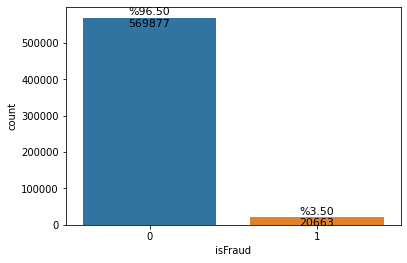

In [ ]:
ax = sns.countplot(x='isFraud', data= train)
labels(ax, train)

##Handling Missing Values

In [ ]:
missig_rate = np.product(train.isnull().sum().sum())/ np.product(train.shape)*100
print(f'missing value in train data: {missig_rate:.2f}%')

missig_rate = np.product(test.isnull().sum().sum())/ np.product(test.shape)*100
print(f'missing value in test data: {missig_rate:.2f}%')


missing value in train data: 45.18%
missing value in test data: 41.20%


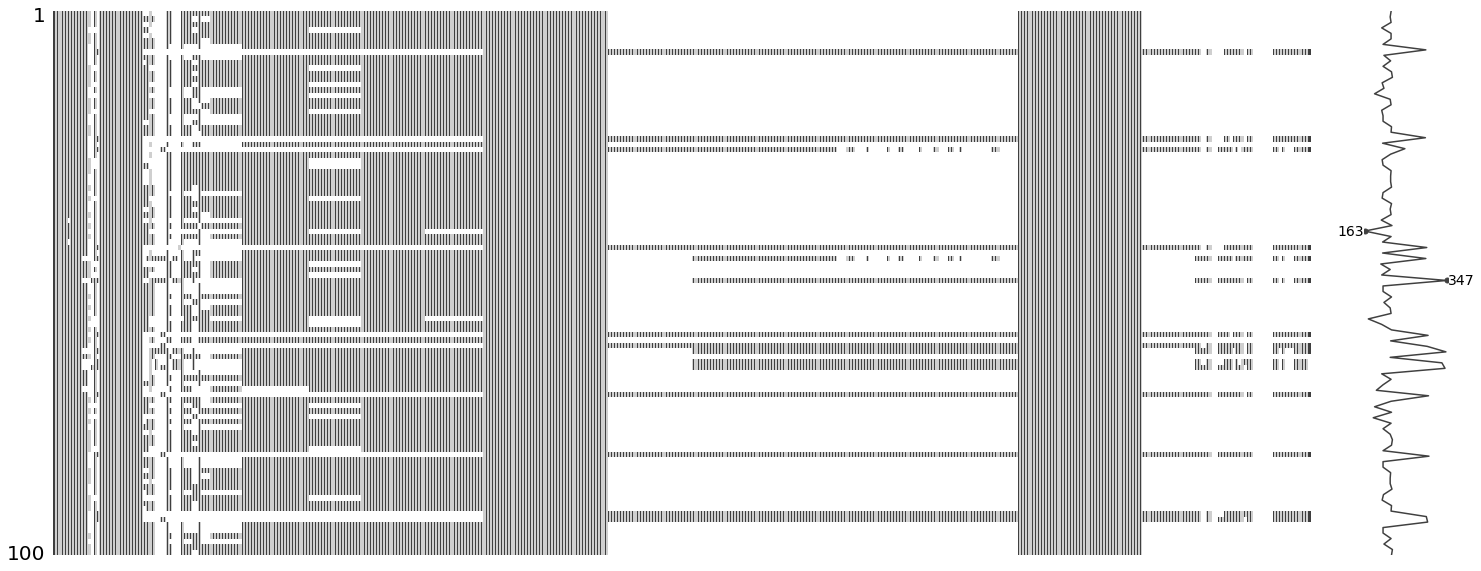

In [ ]:
import missingno as msno
msno.matrix(train.sample(100));

In [ ]:
null_values(train, 90)

,Missing_Records,Percentage (%)
id_24,585793,99.196159
id_25,585408,99.130965
id_07,585385,99.127070
id_08,585385,99.127070
id_21,585381,99.126393
id_26,585377,99.125715
id_22,585371,99.124699
id_23,585371,99.124699
id_27,585371,99.124699
dist2,552913,93.628374


In [ ]:
null_values(test, 90)

,Missing_Records,Percentage (%)
id_24,501951,99.064519
id_25,501652,99.005508
id_26,501644,99.003929
id_07,501632,99.001561
id_08,501632,99.001561
id_21,501632,99.001561
id_22,501629,99.000969
id_23,501629,99.000969
id_27,501629,99.000969
dist2,470255,92.809030


##Dropping useless columns


Columns containing only 1 unique value and containing more than 90 percent missing values and when missing values are dropped, columns with more than 90 percent of the remaining data are dropped from the dataset.

In [ ]:
one_value_cols, many_null_cols, big_top_value_cols =[],[],[] 

for df in [train, test]:
  one_value_cols += [col for col in df.columns if df[col].nunique() == 1]
  many_null_cols += [col for col in df.columns if df[col].isnull().sum() / df.shape[0] > 0.9]
  big_top_value_cols += [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(one_value_cols + many_null_cols + big_top_value_cols))

if 'isFraud' in cols_to_drop: 
  cols_to_drop.remove('isFraud')

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

print(f'{len(cols_to_drop)} features are going to be dropped for being useless')

82 features are going to be dropped for being useless


##Transaction DT

In [ ]:
(train['TransactionDT']//(3600*24)).describe()

count    590540.000000
mean         84.729199
std          53.437277
min           1.000000
25%          35.000000
50%          84.000000
75%         130.000000
max         182.000000
Name: TransactionDT, dtype: float64

In [ ]:
(test['TransactionDT']//(3600*24)).describe()

count    506691.000000
mean        311.086427
std          55.058802
min         213.000000
25%         263.000000
50%         314.000000
75%         362.000000
max         395.000000
Name: TransactionDT, dtype: float64

In [ ]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

####Sorting holiday dates


In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

In [ ]:
for k, df in enumerate([train, test]):
  df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
  df['DT_M'] = ((df['DT'].dt.year-2017-k)*12 + df['DT'].dt.month).astype(np.int8).apply(lambda x: x%12 if x>12 else x)
  df['DT_W'] = ((df['DT'].dt.year-2017-k)*52 + df['DT'].dt.weekofyear).astype(np.int8).apply(lambda x: x%52 if x>52 else x)
  df['DT_D'] = ((df['DT'].dt.year-2017-k)*365 + df['DT'].dt.dayofyear).astype(np.int16).apply(lambda x: x%365 if x>365 else x)
  
  df['DT_hour'] = (df['DT'].dt.hour).astype(np.int8)
  df['DT_day_week'] = (df['DT'].dt.dayofweek).astype(np.int8)
  df['DT_day_month'] = (df['DT'].dt.day).astype(np.int8)

  # Holidays
  df['DT_holiday'] = (df['DT'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

In [ ]:
train = train.drop('DT',axis=1)
test = test.drop('DT',axis=1)

In [ ]:
pip install colorama

In [ ]:
for df in [train, test]:
  column_details(regex='^DT_.*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DT_M:  int64, 6, %0.0
[ 1  2  3  4  5 12]

DT_W:  int64, 27, %0.0
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 48 49
 50 51 52]

DT_D:  int64, 182, %0.0
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365]

DT_hour:  int8, 2

###T_DT visualisation

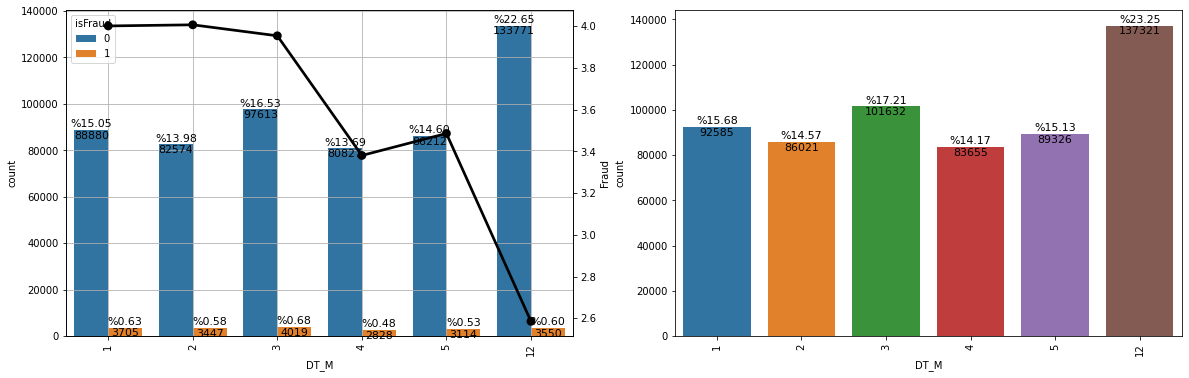

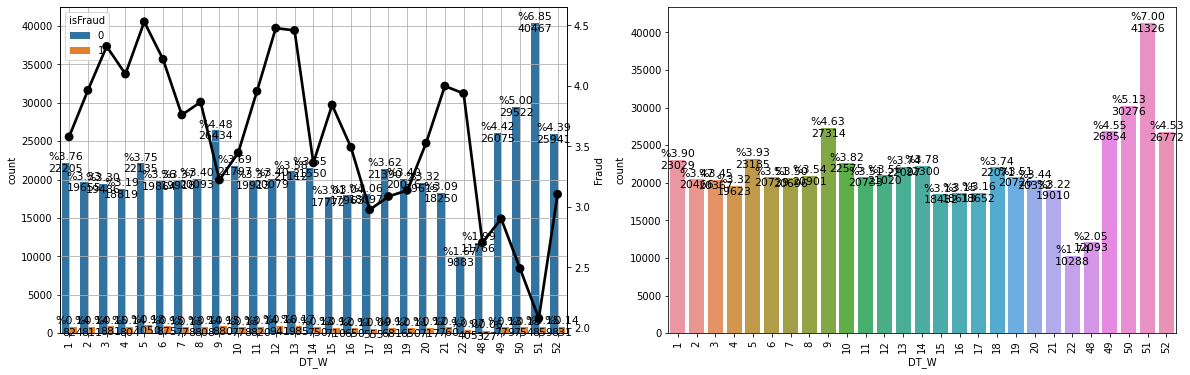

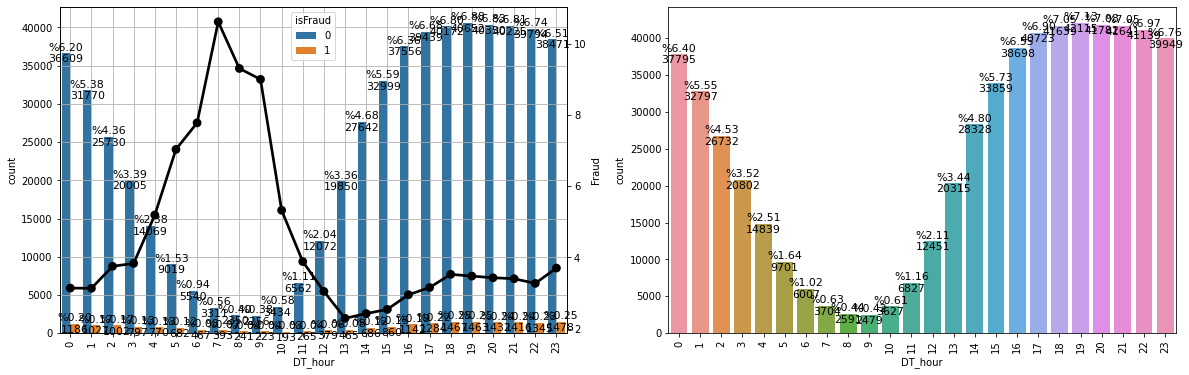

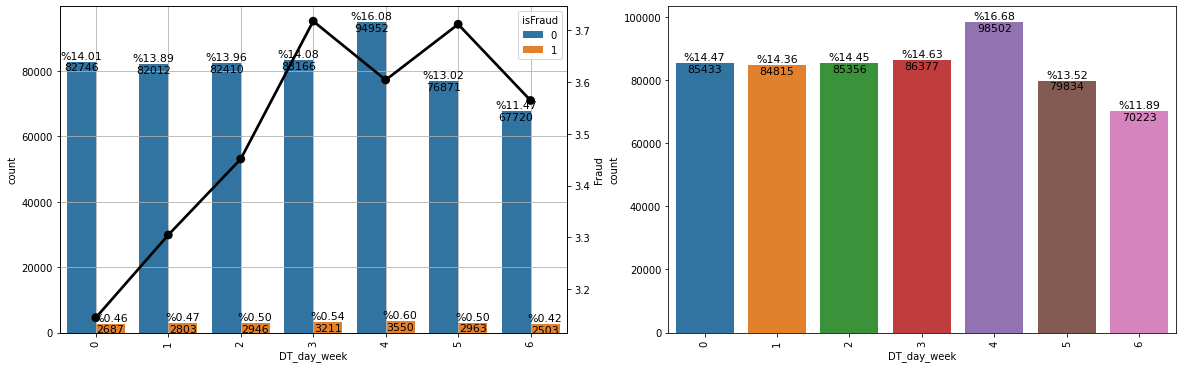

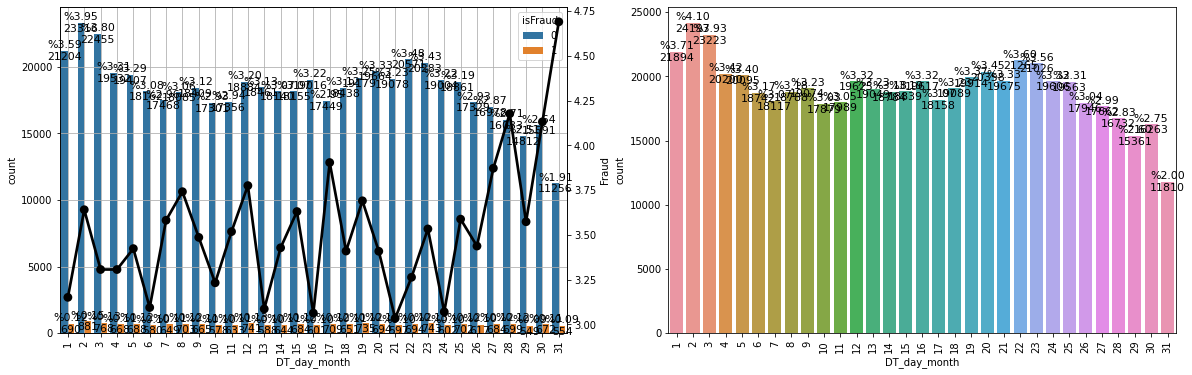

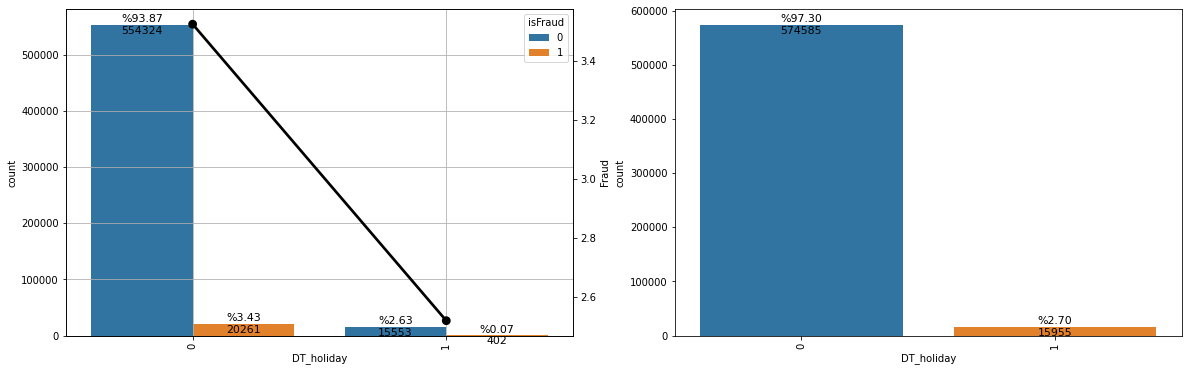

In [ ]:
columns=[col for col in train.columns if re.search('^DT_.*', col)]
columns.remove('DT_D')

for col in columns:
  plot_col(col, df=train)

##TransactionAmt

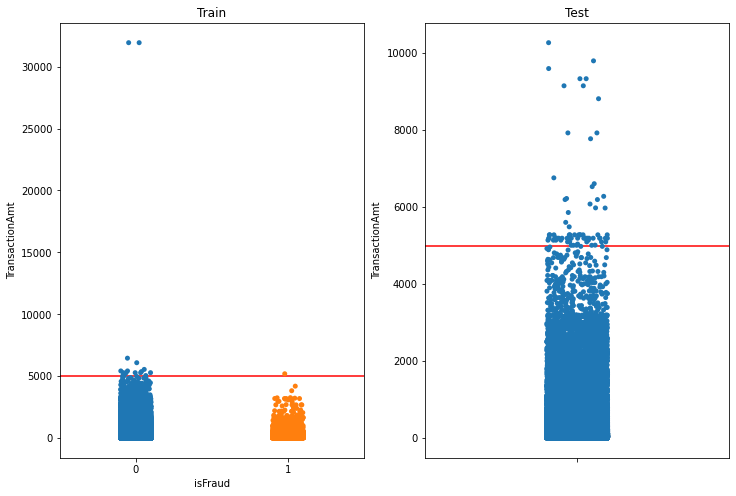

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='TransactionAmt', x='isFraud', data=train)
plt.axhline(5000, color='red')
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='TransactionAmt', data=test)
plt.axhline(5000, color='red')
plt.title('Test');

In [ ]:
for df in [train, test]:
  df['TransactionAmt'] = df['TransactionAmt'].clip(0,5000)

In [ ]:
train[train.isFraud==1]['TransactionAmt'].mean(), \
train[train.isFraud==0]['TransactionAmt'].mean(), \
train['TransactionAmt'].mean(), \
test['TransactionAmt'].mean()

(149.2360076904297, 134.26495361328125, 134.77645874023438, 134.49339294433594)

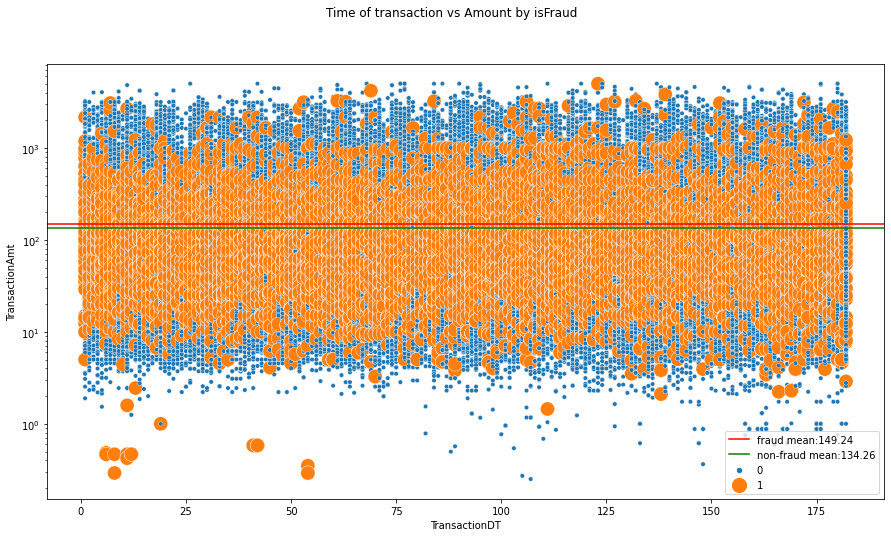

In [ ]:
plt.figure(figsize=(15,8))
plt.suptitle('Time of transaction vs Amount by isFraud')
fraud_mean, nonfraud_mean = train[train.isFraud==1]['TransactionAmt'].mean(), train[train.isFraud==0]['TransactionAmt'].mean()
sns.scatterplot(x=train['TransactionDT']//(3600*24), y=train['TransactionAmt'], data=train, hue='isFraud', size="isFraud", sizes=(200, 20))
plt.axhline(y=fraud_mean ,color='red',label=f'fraud mean:{round(fraud_mean,2)}')
plt.axhline(y=nonfraud_mean, color='green',label=f'non-fraud mean:{round(nonfraud_mean,2)}')
plt.legend()

plt.yscale('log')
plt.show()

##id_30

In [ ]:
for df in [train, test]:
  column_details(regex='id_30', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

id_30:  object, 75, %86.87
['Android' 'Android 4.4.2' 'Android 5.0' 'Android 5.0.2' 'Android 5.1.1'
 'Android 6.0' 'Android 6.0.1' 'Android 7.0' 'Android 7.1.1'
 'Android 7.1.2' 'Android 8.0.0' 'Android 8.1.0' 'Linux' 'Mac'
 'Mac OS X 10.10' 'Mac OS X 10.11' 'Mac OS X 10.12' 'Mac OS X 10.13'
 'Mac OS X 10.6' 'Mac OS X 10.9' 'Mac OS X 10_10_5' 'Mac OS X 10_11_3'
 'Mac OS X 10_11_4' 'Mac OS X 10_11_5' 'Mac OS X 10_11_6' 'Mac OS X 10_12'
 'Mac OS X 10_12_1' 'Mac OS X 10_12_2' 'Mac OS X 10_12_3'
 'Mac OS X 10_12_4' 'Mac OS X 10_12_5' 'Mac OS X 10_12_6'
 'Mac OS X 10_13_1' 'Mac OS X 10_13_2' 'Mac OS X 10_13_3'
 'Mac OS X 10_13_4' 'Mac OS X 10_13_5' 'Mac OS X 10_6_8' 'Mac OS X 10_7_5'
 'Mac OS X 10_8_5' 'Mac OS X 10_9_5' 'Windows' 'Windows 10' 'Windows 7'
 'Windows 8' 'Windows 8.1' 'Windows Vista' 'Windows XP' 'func' 'iOS'
 'iOS 10.0.2' 'iOS 10.1.1' 'iOS 10.2.0' 'iOS 10.2.1' 'iOS 10.3.1'
 'iOS 10.3.2' 'iOS 10.3.3' 'iOS 11.0.0

In [ ]:
old_versions_id_30 = set(train['id_30'].unique()) - set(test['id_30'].unique())
new_versions_id_30 = set(test['id_30'].unique()) - set(train['id_30'].unique())

In [ ]:
test['id_30'] =test['id_30'].apply(lambda x: np.nan if x in new_versions_id_30 else x)
train['id_30'] =train['id_30'].apply(lambda x: np.nan if x in old_versions_id_30 else x)

##id_31

In [ ]:
for df in [train, test]:
  column_details(regex='id_31', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

id_31:  object, 130, %76.25
['BLU/Dash' 'Cherry' 'Generic/Android' 'Generic/Android 7.0' 'Inco/Minion'
 'LG/K-200' 'Lanix/Ilium' 'M4Tel/M4' 'Microsoft/Windows' 'Mozilla/Firefox'
 'Nokia/Lumia' 'Samsung/SCH' 'Samsung/SM-G531H' 'Samsung/SM-G532M'
 'ZTE/Blade' 'android' 'android browser 4.0' 'android webview 4.0' 'aol'
 'chrome' 'chrome 43.0 for android' 'chrome 46.0 for android'
 'chrome 49.0' 'chrome 49.0 for android' 'chrome 50.0 for android'
 'chrome 51.0' 'chrome 51.0 for android' 'chrome 52.0 for android'
 'chrome 53.0 for android' 'chrome 54.0 for android' 'chrome 55.0'
 'chrome 55.0 for android' 'chrome 56.0' 'chrome 56.0 for android'
 'chrome 57.0' 'chrome 57.0 for android' 'chrome 58.0'
 'chrome 58.0 for android' 'chrome 59.0' 'chrome 59.0 for android'
 'chrome 60.0' 'chrome 60.0 for android' 'chrome 61.0'
 'chrome 61.0 for android' 'chrome 62.0' 'chrome 62.0 for android'
 'chrome 62.0 for ios' 'chrome 63.0' 'chr

In [ ]:
old_versions_id_31 = set(train['id_31'].unique()) - set(test['id_31'].unique())
new_versions_id_31 = set(test['id_31'].unique()) - set(train['id_31'].unique())

In [ ]:
test['id_31'] =test['id_31'].apply(lambda x: np.nan if x in new_versions_id_31 else x)
train['id_31'] =train['id_31'].apply(lambda x: np.nan if x in old_versions_id_31 else x)

##id_33

In [ ]:
old_versions_id_33 = set(train['id_33'].unique()) - set(test['id_33'].unique())
new_versions_id_33 = set(test['id_33'].unique()) - set(train['id_33'].unique())

In [ ]:
test['id_33'] =test['id_33'].apply(lambda x: np.nan if x in new_versions_id_33 else x)
train['id_33'] =train['id_33'].apply(lambda x: np.nan if x in old_versions_id_33 else x)

##id_12-38

In [ ]:
cramers_v(train.id_28,train.id_29), cramers_v(test.id_28,test.id_29)

(0.9815040862243661, 0.977733347457673)

In [ ]:
train = train.drop('id_29', axis=1)
test = test.drop('id_29', axis=1)

##v1-339

In [ ]:
column_details(regex='V\d*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

V1:  float16, 2, %34.84
[ 0.  1. nan]

V2:  float16, 12, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]

V3:  float16, 12, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]

V4:  float16, 10, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  8.  9. 10. nan]

V5:  float16, 11, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. nan]

V6:  float16, 13, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. nan]

V7:  float16, 13, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. nan]

V8:  float16, 12, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]

V9:  float16, 12, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]

V10:  float16, 6, %34.84
[ 0.  1.  2.  3.  4.  5. nan]

V11:  float16, 8, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7. nan]

V12:  float16, 5, %2.48
[ 0.  1.  2.  3.  4. nan]

V13:  float16, 7, %2.48
[ 0.  1.  2.  3.  4.  5.  6. nan]

V15:  float16, 13, %2.48
[ 0

In [ ]:
columns=[col for col in train.columns if re.search('^V\d*', col)]
len(columns)

270

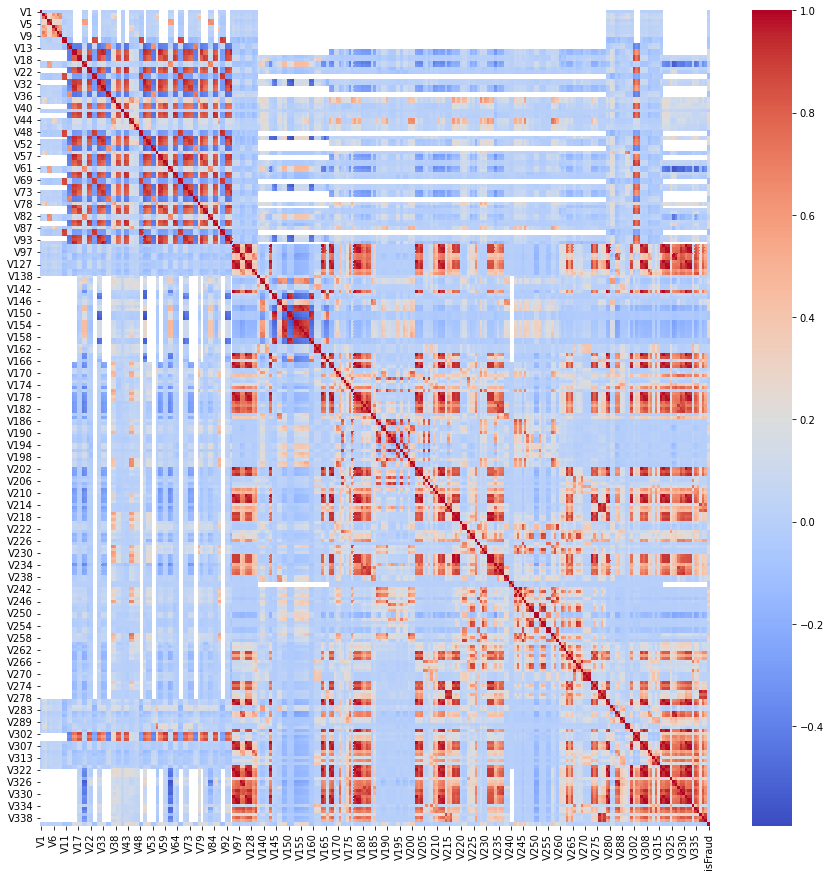

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(train[columns+['isFraud']].sample(frac=0.2).corr(),annot=False, cmap="coolwarm");

In [ ]:
corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
len(drop_col)

208

In [ ]:
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

In [ ]:
columns=[col for col in train.columns if re.search('^V\d*', col)]
len(columns)

62

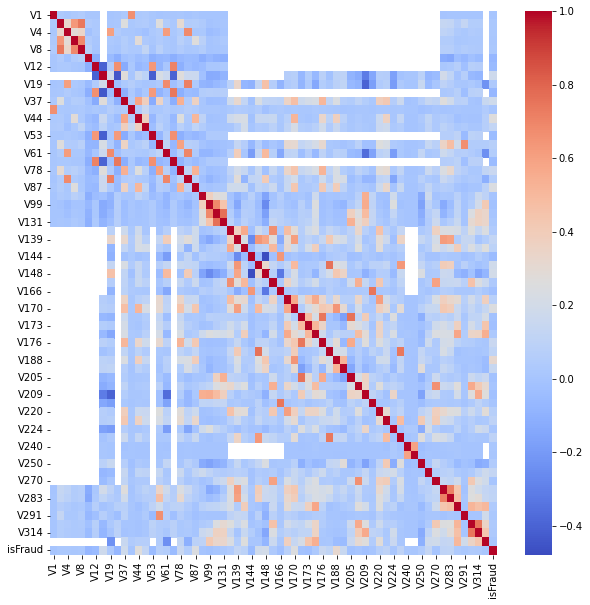

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(train[columns+['isFraud']].sample(frac=0.2).corr(),annot=False, cmap="coolwarm");

##DeviceInfo

In [ ]:
old_versions_DeviceInfo = set(train['DeviceInfo'].unique()) - set(test['DeviceInfo'].unique())
new_versions_DeviceInfo= set(test['DeviceInfo'].unique()) - set(train['DeviceInfo'].unique())

In [ ]:
test['DeviceInfo'] =test['DeviceInfo'].apply(lambda x: np.nan if x in new_versions_DeviceInfo else x)
train['DeviceInfo'] =train['DeviceInfo'].apply(lambda x: np.nan if x in old_versions_DeviceInfo else x)

##Device Type

In [ ]:
for df in [train, test]:
  column_details(regex='DeviceType', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceType:  object, 2, %76.16
['desktop' 'mobile' nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceType:  object, 2, %72.98
['desktop' 'mobile' nan]



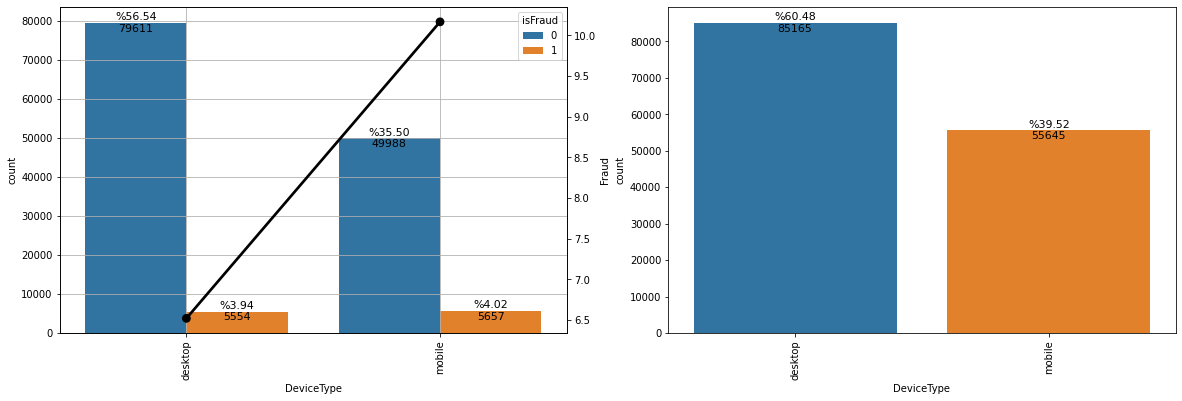

In [ ]:
plot_col('DeviceType', df=train)

##Email

In [ ]:
column_details(regex='R_emaildomain', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

R_emaildomain:  object, 60, %76.75
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'scranton.edu' 'servicios-ta.com' 'suddenlink.net' 'twc.com'
 'verizon.net' 'web.de' 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk'
 'yahoo.com' 'yahoo.com.mx' 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com'
 nan]



In [ ]:
for df in [train, test]:
  df['R_emaildomain_1'] = df['R_emaildomain'].fillna('').apply(lambda x: x.split(".")[0]).replace({'':np.nan})
  df['R_emaildomain_2'] = df['R_emaildomain'].str.split('.', expand=True).iloc[:,1:].fillna('').apply(lambda x:('.'.join(x)).strip('.'), axis=1).replace({'':np.nan})

##P_emaildomain

In [ ]:
column_details(regex='P_emaildomain', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

P_emaildomain:  object, 59, %15.99
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'servicios-ta.com' 'suddenlink.net' 'twc.com' 'verizon.net' 'web.de'
 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk' 'yahoo.com' 'yahoo.com.mx'
 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com' nan]



In [ ]:
for df in [train, test]:
  df['P_emaildomain_1'] = df['P_emaildomain'].fillna('').apply(lambda x: x.split(".")[0]).replace({'':np.nan})
  df['P_emaildomain_2'] = df['P_emaildomain'].str.split('.', expand=True).iloc[:,1:].fillna('').apply(lambda x:('.'.join(x)).strip('.'), axis=1).replace({'':np.nan})

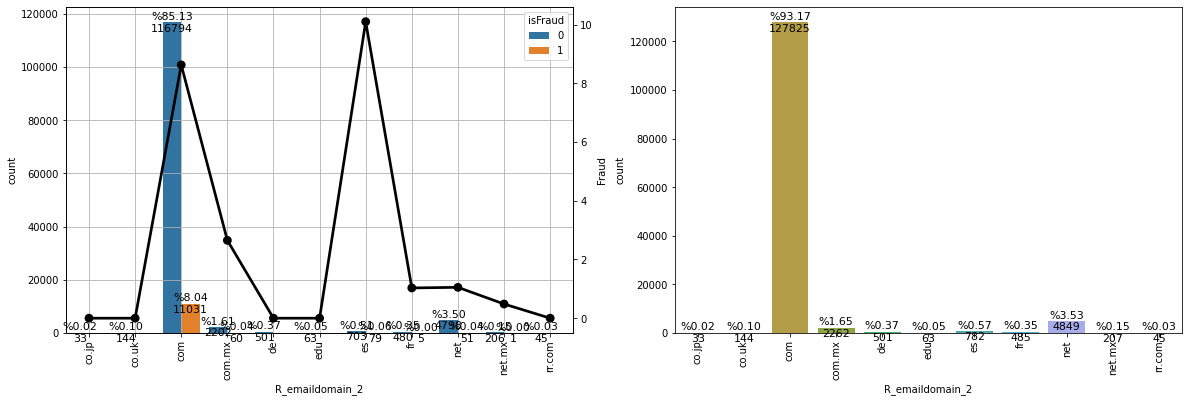

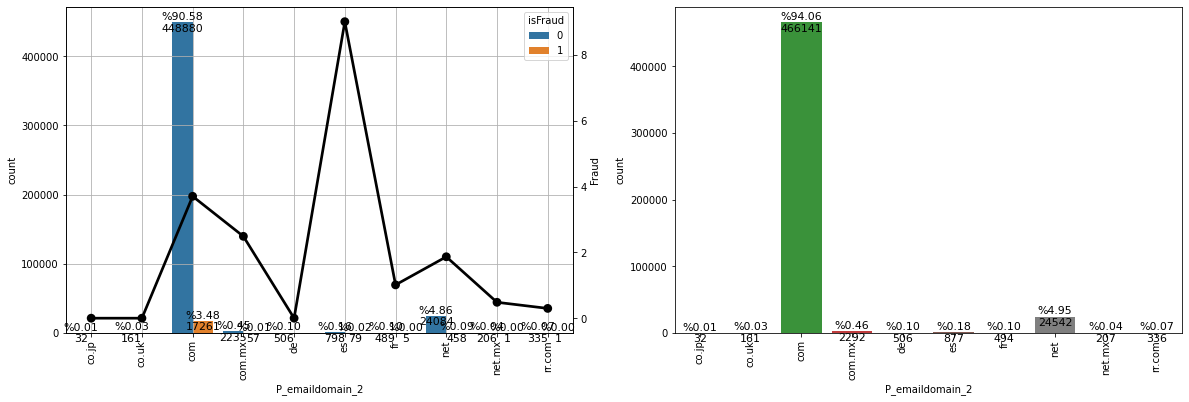

In [ ]:
for col in ['R_emaildomain_2', 'P_emaildomain_2']:
  plot_col(col, df=train)

In [ ]:
cramers_v(train.R_emaildomain_2,train.P_emaildomain_2)

0.8911182952794453

In [ ]:
cramers_v(test.R_emaildomain_2,test.P_emaildomain_2)

0.9053937957212637

In [ ]:
train = train.drop(['R_emaildomain','P_emaildomain','P_emaildomain_2'], axis=1)
test = test.drop(['R_emaildomain','P_emaildomain','P_emaildomain_2'], axis=1)

##addr1-2

In [ ]:
for df in [train, test]:
  column_details(regex='addr', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

addr1:  float16, 332, %11.13
[100. 101. 102. 104. 105. 106. 110. 111. 112. 113. 117. 119. 120. 122.
 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 137. 139.
 141. 142. 143. 144. 145. 146. 148. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 164. 166. 167. 168. 170. 171. 172. 174.
 177. 178. 180. 181. 182. 183. 184. 185. 187. 189. 190. 191. 193. 194.
 195. 196. 198. 199. 200. 201. 202. 203. 204. 205. 206. 208. 210. 211.
 213. 214. 215. 216. 217. 218. 219. 220. 221. 223. 224. 225. 226. 227.
 231. 232. 233. 234. 235. 236. 237. 238. 239. 241. 242. 243. 244. 245.
 247. 248. 249. 250. 251. 252. 253. 254. 255. 257. 258. 259. 260. 261.
 262. 264. 265. 268. 269. 270. 272. 274. 275. 276. 277. 278. 279. 280.
 282. 283. 284. 286. 290. 292. 294. 295. 296. 297. 298. 299. 300. 301.
 302. 303. 304. 305. 306. 307. 308. 309. 310. 312. 313. 314. 315. 316.
 318. 321. 322. 323. 324. 325. 326. 327. 328. 329. 3

In [ ]:
for df in [train, test]:
  df['addr'] = (df['addr2'].astype(str)+'_'+df['addr1'].astype(str)).replace({'nan_nan':np.nan})

In [ ]:
train['addr1'].nunique(), train['addr2'].nunique(), train['addr'].nunique()

(332, 74, 437)

In [ ]:
test['addr1'].nunique(), test['addr2'].nunique(), test['addr'].nunique()

(292, 72, 394)

##card1

In [ ]:
gc.collect()

26911

In [ ]:
old_versions_card1 = set(train['card1'].unique()) - set(test['card1'].unique())
new_versions_card1 = set(test['card1'].unique()) - set(train['card1'].unique())

In [ ]:
len(old_versions_card1), len(new_versions_card1)

(3847, 3538)

In [ ]:
test['card1'] =test['card1'].apply(lambda x: np.nan if x in new_versions_card1 else x)
train['card1'] =train['card1'].apply(lambda x: np.nan if x in old_versions_card1 else x)

In [ ]:
rareCards=[]
for k, df in enumerate([train, test]):
  rare_cards = df.card1.value_counts()
  rare_cards = rare_cards.where(rare_cards<3).dropna().sort_index().index
  rareCards += list(rare_cards)

  print(f"{('TEST' if k else 'TRAIN')}")
  print(f"Number of unique in card1: {df.card1.nunique()}")
  print(f"Number of unique values with frequency less than 3 in card1: {len(rare_cards)}\n")
rareCards = set(rareCards)

TRAIN
Number of unique in card1: 9706
Number of unique values with frequency less than 3 in card1: 2344

TEST
Number of unique in card1: 9706
Number of unique values with frequency less than 3 in card1: 2635



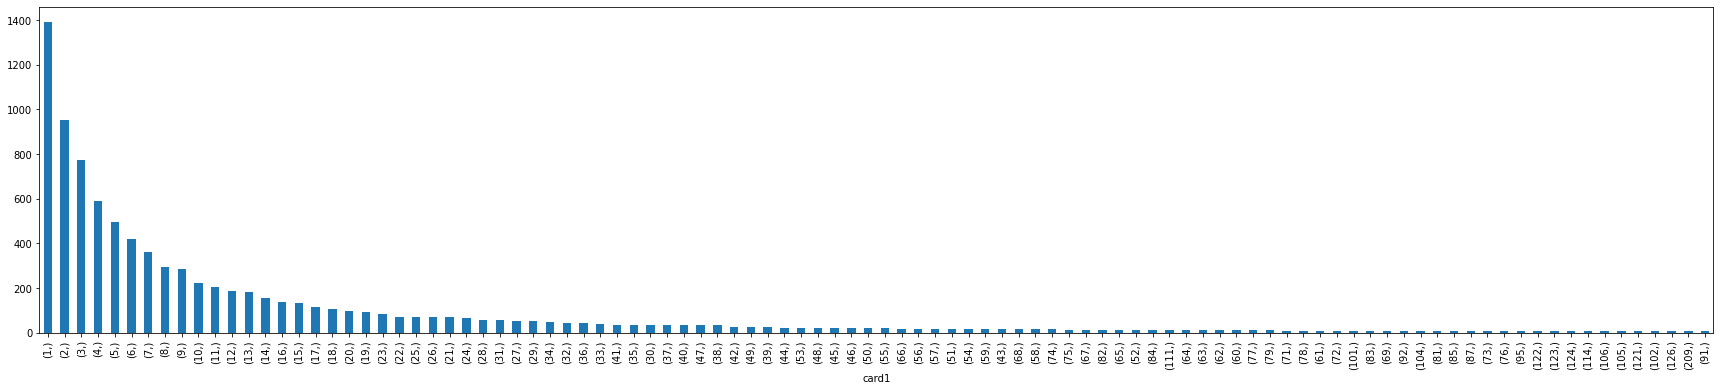

In [ ]:
# Countplot of the frequency of the unique value frequencies in card1
plt.figure(figsize=(30,6))
train.card1.value_counts().to_frame().value_counts().head(100).plot.bar();

In [ ]:
for df in [train, test]:
  df['card1'] = df['card1'].apply(lambda x: np.nan if x in rareCards else x)

In [ ]:
column_details(regex='^card', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

card1:  float64, 6118, %3.74
[ 1004.  1006.  1008. ... 18393. 18395.    nan]

card2:  float16, 500, %1.51
[100. 101. 102. 103. 104. 105. 106. 108. 109. 110. 111. 112. 113. 114.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142.
 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156.
 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184.
 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198.
 199. 200. 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212.
 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223. 224. 225. 226.
 227. 228. 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 239. 240.
 241. 242. 243. 244. 245. 246. 247. 248. 249. 250. 251. 252. 253. 254.
 255. 256. 257. 258. 259. 260. 261. 262. 263. 

In [ ]:
for col in ['card2','card3','card4','card5','card6']: 
  old_versions_col= set(train[col].unique()) - set(test[col].unique())
  new_versions_col = set(test[col].unique()) - set(train[col].unique()) 
  test[col] =test[col].apply(lambda x: np.nan if x in new_versions_col else x)
  train[col] =train[col].apply(lambda x: np.nan if x in old_versions_col else x)

##D8-9

In [ ]:
null_values(train[['D8','D9']])

,Missing_Records,Percentage (%)
D8,515614,87.31229
D9,515614,87.31229


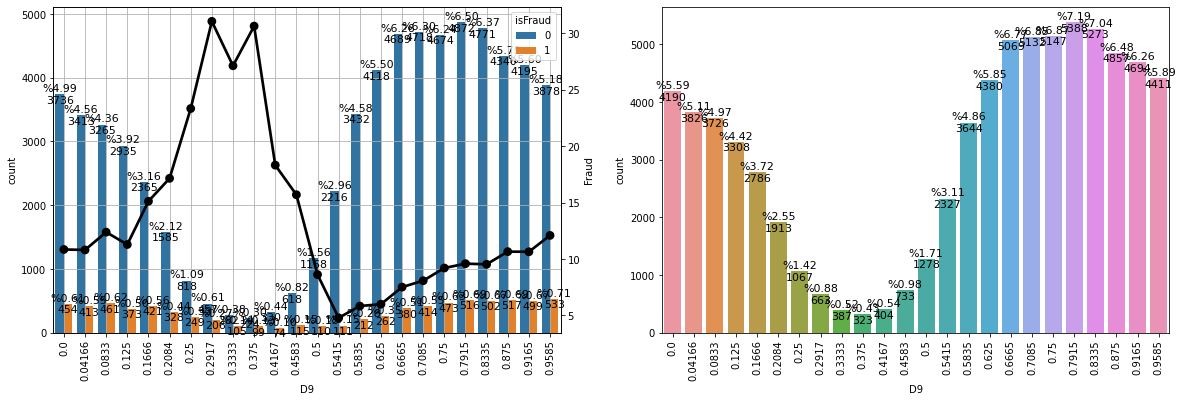

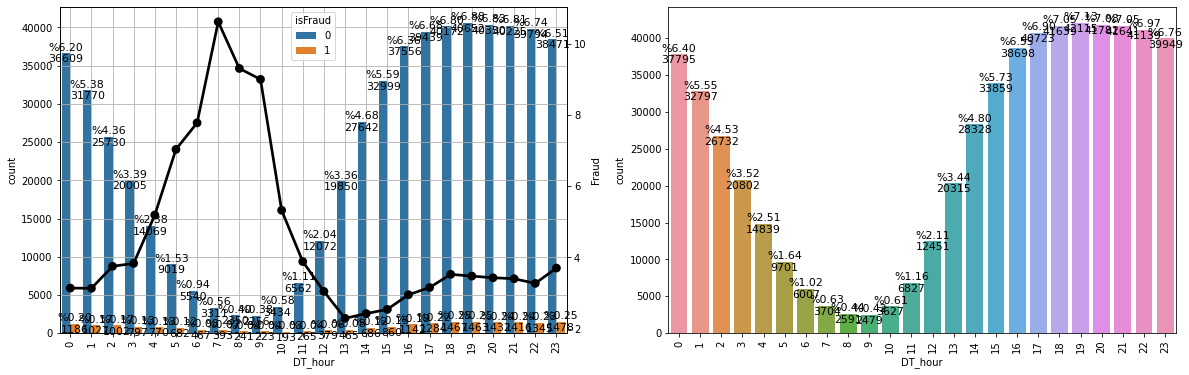

In [ ]:
for col in ['D9','DT_hour']:
  plot_col(col, df=train)

In [ ]:
train[['D9', 'DT_hour']].corr()

,D9,DT_hour
D9,1.0,1.0
DT_hour,1.0,1.0


In [ ]:
train.D8.describe()

count    74926.000000
mean              NaN
std               NaN
min          0.000000
25%          0.958496
50%         37.875000
75%        188.000000
max       1708.000000
Name: D8, dtype: float64

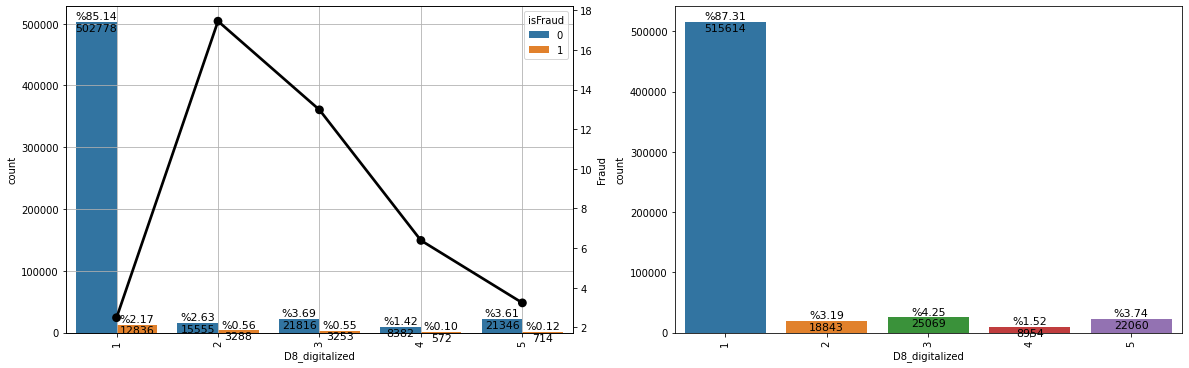

In [ ]:
for df in [train, test]:
  df['D8_digitalized'] = pd.Series(np.digitize(df['D8'].fillna(-1), bins=[-1,0,1,75,150,1710]))
  df['D8'] = df['D8'].fillna(-1).astype(int)

plot_col('D8_digitalized', df=train)

##D1-15

In [ ]:
for df in [train, test]:
  column_details(regex='^D\d.*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

D1:  float16, 641, %0.21
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 

In [ ]:
columns=[col for col in train.columns if re.search('^D\d.*', col)]+['DT_hour']

corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
drop_col


{'D12', 'D15', 'D2', 'D6', 'DT_hour'}

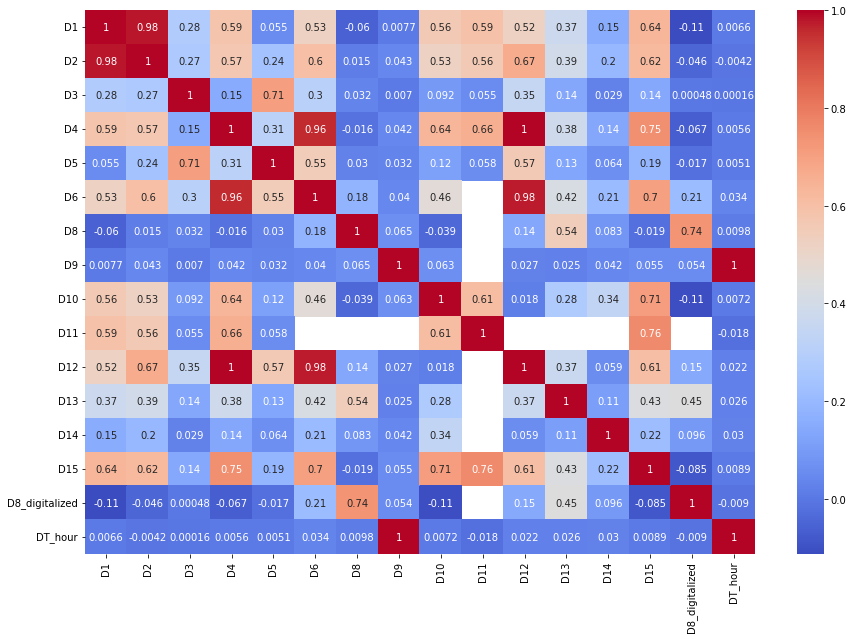

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(train[columns].corr(),annot=True, cmap="coolwarm");

In [ ]:
drop_col={'D12', "D11", 'D2', 'D6', 'D9'}

In [ ]:
for df in [train, test]:
  df = df.drop(drop_col, axis=1)

##c1-14

In [ ]:
column_details(regex='^C\d', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

C1:  float16, 1495, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 4.672e+03 4.680e+03 4.684e+03]

C2:  float16, 1167, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 5.624e+03 5.688e+03 5.692e+03]

C4:  float16, 1223, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 2.248e+03 2.250e+03 2.252e+03]

C5:  float16, 319, %0.0
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.

In [ ]:
columns=[col for col in train.columns if re.search('^C\d.*', col)]
corr_treshold = 0.9
drop_col = remove_collinear_features(train[columns],corr_treshold)
drop_col

{'C10', 'C11', 'C12', 'C14', 'C2', 'C4', 'C6', 'C7', 'C8', 'C9'}

In [ ]:
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

##dist1-2

In [ ]:
column_details(regex='^dist', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

dist1:  float16, 1918, %57.47
[0.000e+00 1.000e+00 2.000e+00 ... 7.384e+03 8.080e+03       nan]



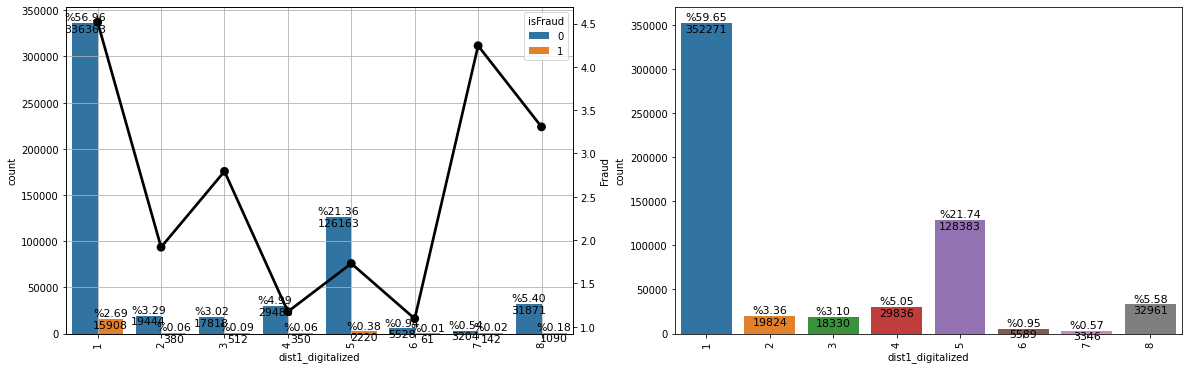

In [ ]:
for df in [train, test]:  
  df['dist1_digitalized'] = pd.Series(np.digitize(df['dist1'].fillna(-1), bins=[-1,0,1,2,4,50,75,100,10300]))

plot_col('dist1_digitalized', df=train)

In [ ]:
  train = train.drop('dist1', axis=1)
  test = test.drop('dist1', axis=1)

##m1-9

In [ ]:
column_details(regex='^M\d*', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

M1:  object, 2, %45.91
['F' 'T' nan]

M2:  object, 2, %45.91
['F' 'T' nan]

M3:  object, 2, %45.91
['F' 'T' nan]

M4:  object, 3, %47.66
['M0' 'M1' 'M2' nan]

M5:  object, 2, %59.35
['F' 'T' nan]

M6:  object, 2, %28.68
['F' 'T' nan]

M7:  object, 2, %58.64
['F' 'T' nan]

M8:  object, 2, %58.63
['F' 'T' nan]

M9:  object, 2, %58.63
['F' 'T' nan]



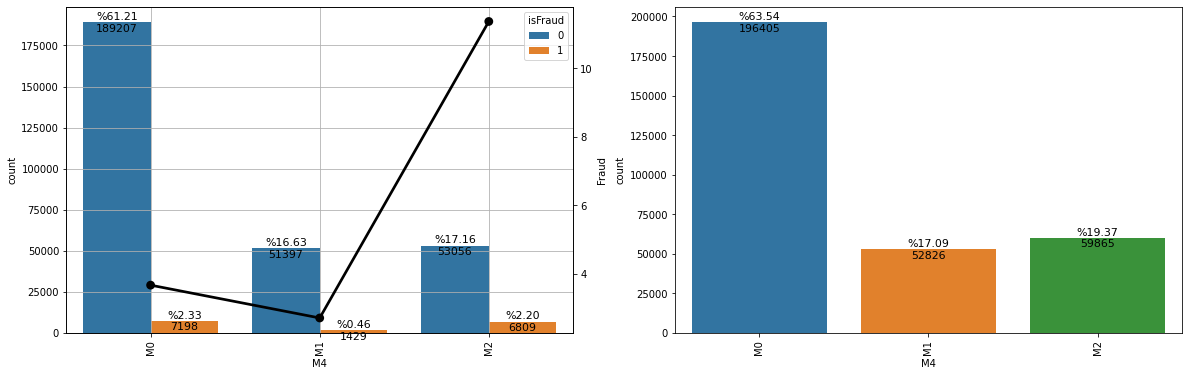

In [ ]:
plot_col('M4', df=train)

In [ ]:
temp_dict = train.groupby(['M4'])['isFraud'].agg(['mean']).to_dict()['mean']
train['M4_target_mean'] = train['M4'].replace(temp_dict)
test['M4_target_mean']  = test['M4'].replace(temp_dict)

##ProductCD

In [ ]:
for df in [train, test]:
  column_details(regex='ProductCD', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

ProductCD:  object, 5, %0.0
['C' 'H' 'R' 'S' 'W']

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

ProductCD:  object, 5, %0.0
['C' 'H' 'R' 'S' 'W']



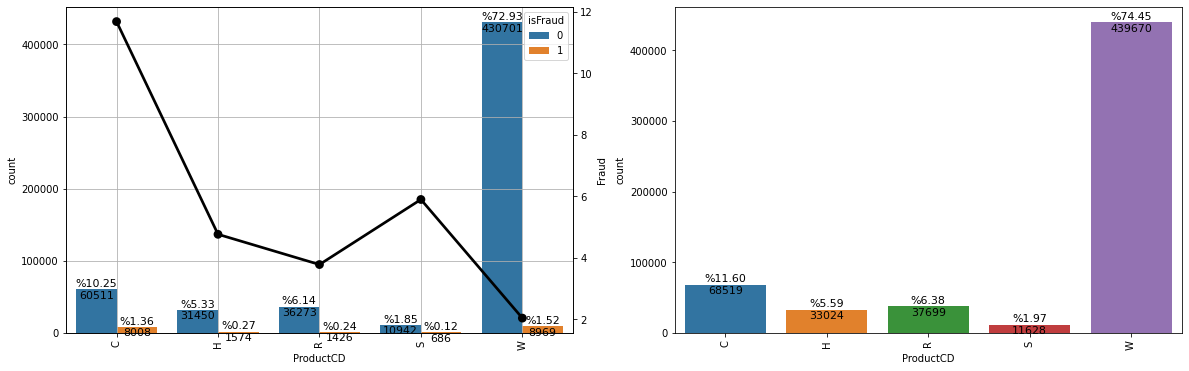

In [ ]:
plot_col('ProductCD', df=train)

In [ ]:
temp_dict = train.groupby(['ProductCD'])['isFraud'].agg(['mean']).to_dict()['mean']
train['ProductCD_target_mean'] = train['ProductCD'].replace(temp_dict)
test['ProductCD_target_mean']  = test['ProductCD'].replace(temp_dict)

##Frequency Encoders

In [ ]:
self_encode_True= ['ProductCD', 'DeviceInfo', 'DeviceType', 'addr'] + \
                  ['R_emaildomain_1', 'R_emaildomain_2','P_emaildomain_1'] + \
                  ['id_12','id_15','id_16','id_28','id_30','id_31','id_33',"id_34",'id_35', 'id_36', 'id_37', 'id_38'] + \
                  ['M1','M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']+ \
                  ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15'] + \
                  [ 'card4', 'card6']

self_encode_False=['card1', 'card2', 'card3', 'card5']+ \
                  ['C1', 'C5', 'C13']

In [ ]:
train, test = frequency_encoding(train, test, self_encode_True, self_encoding=True)
train, test = frequency_encoding(train, test, self_encode_False, self_encoding=False)

In [ ]:
train.to_pickle('./train_2.pkl') 
test.to_pickle('./test_2.pkl')

# train= pd.read_pickle('./train_2.pkl') 
# test= pd.read_pickle('./test_2.pkl')

gc.collect()

20532

#PCA for V columns

In [ ]:
V_columns = [col for col in train.columns if re.search('^V\d*', col)]
train[V_columns] = train[V_columns].fillna(-1)
test[V_columns] = test[V_columns].fillna(-1)

sc_V = MinMaxScaler()
sc_V.fit(train[V_columns])
train[V_columns] = sc_V.transform(train[V_columns])
test[V_columns] = sc_V.transform(test[V_columns])

In [ ]:
# df = pd.concat([train, test], ignore_index=True, sort=False)

# plt.figure(figsize=(25,6))
# pca = PCA().fit(df[columns])
# plt.plot(range(1,64),np.cumsum(pca.explained_variance_ratio_), "bo-")
# plt.xlabel("Component Count")
# plt.ylabel("Variance Ratio")
# plt.xticks(range(1,df[columns].shape[1]+1))
# plt.grid()
# plt.show()

In [ ]:
del df

In [ ]:
pca = PCA(n_components = 3)
pca.fit(train[V_columns])
pca_V_train = pca.transform(train[V_columns])
pca_V_test = pca.transform(test[V_columns])

np.cumsum(pca.explained_variance_ratio_)

array([0.58156788, 0.84889753, 0.91030364])

In [ ]:
gc.collect()


50

In [ ]:
pca_V_train = pd.DataFrame(data = pca_V_train).add_prefix('pca_V')
train = pd.concat([train, pca_V_train], ignore_index=False, sort=False, axis=1)
train.drop(V_columns, axis=1, inplace=True)

pca_V_test = pd.DataFrame(data = pca_V_test).add_prefix('pca_V')
test = pd.concat([test, pca_V_test], ignore_index=False, sort=False, axis=1)
test.drop(V_columns, axis=1, inplace=True)

In [ ]:
del pca_V_train, pca_V_test

In [ ]:
train = train.drop('TransactionDT',axis=1)
test = test.drop('TransactionDT',axis=1)

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

train.to_pickle('./train_3.pkl') 
test.to_pickle('./test_3.pkl')

gc.collect()

Mem. usage decreased to 119.19 Mb (64.5% reduction)
Mem. usage decreased to 87.95 Mb (67.8% reduction)


0

Export Data

In [ ]:
# train= pd.read_pickle('./train_3.pkl') 
# test= pd.read_pickle('./test_3.pkl')

#LightGBM Model

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# for modeling 
import sklearn
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, recall_score, f1_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, plot_roc_curve, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets, metrics
from sklearn.decomposition import PCA

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")



warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [ ]:
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

In [ ]:
lgb = LGBMClassifier(
          max_bin = 63,
          num_leaves = 255,
          num_iterations = 500,
          learning_rate = 0.01,
          tree_learner = 'serial',
          is_dfing_metric = False,
          min_data_in_leaf = 1,
          min_sum_hessian_in_leaf = 100,
          sparse_threshold=1.0,
          # device = 'gpu',
          num_thread = -1,
          save_binary= True,
          seed= 42,
          feature_fraction_seed = 42,
          bagging_seed = 42,
          drop_seed = 42,
          data_random_seed = 42,
          objective = 'binary',
          boosting_type = 'gbdt',
          verbose = 1,
          metric = 'auc',
          is_unbalance = True,
          boost_from_average = False,
)

In [ ]:
%time 
lgb.fit(X_train, y_train)
# %time prints CPU Times and Wall Time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


LGBMClassifier(bagging_seed=42, boost_from_average=False, data_random_seed=42,
               drop_seed=42, feature_fraction_seed=42, is_dfing_metric=False,
               is_unbalance=True, learning_rate=0.01, max_bin=63, metric='auc',
               min_data_in_leaf=1, min_sum_hessian_in_leaf=100,
               num_iterations=500, num_leaves=255, num_thread=-1,
               objective='binary', save_binary=True, seed=42,
               sparse_threshold=1.0, tree_learner='serial', verbose=1)

In [ ]:
gc.collect()

253

#Model Evaluation


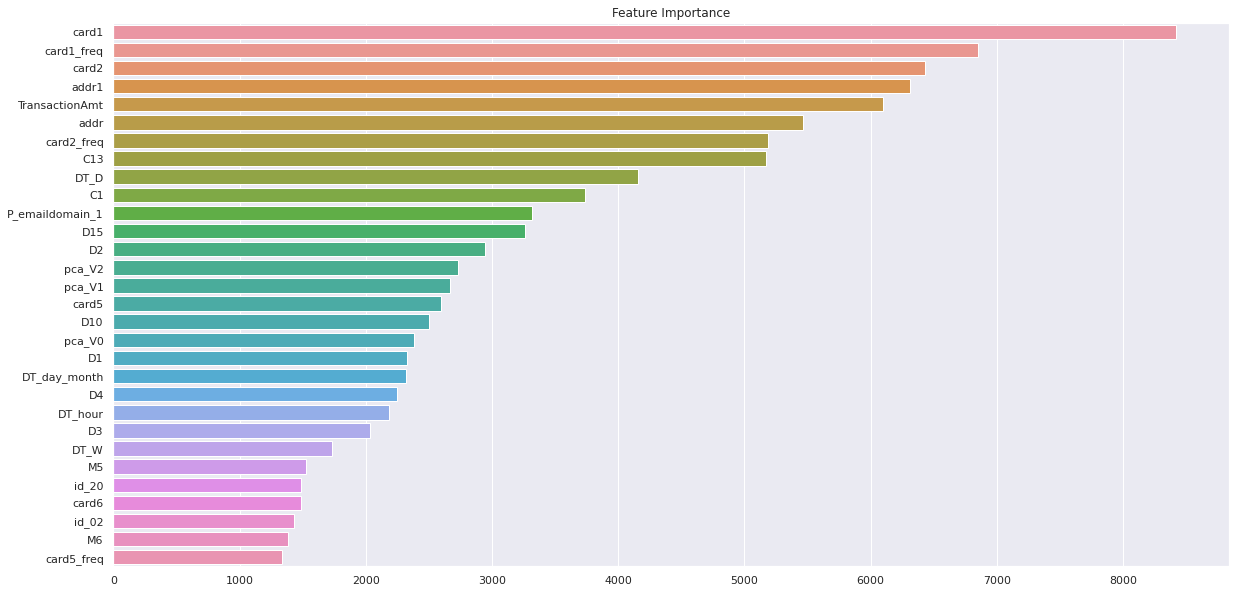

In [ ]:
plot_feature_importances(lgb, 30)

In [ ]:
y_pred = lgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    142469
           1       0.31      0.83      0.45      5166

    accuracy                           0.93    147635
   macro avg       0.65      0.88      0.70    147635
weighted avg       0.97      0.93      0.94    147635



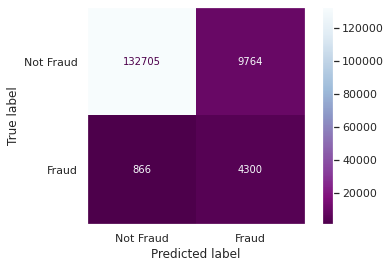

In [ ]:
plot_confusion_matrix(lgb, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'], cmap=plt.cm.BuPu_r)
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    427408
           1       0.34      0.93      0.50     15497

    accuracy                           0.93    442905
   macro avg       0.67      0.93      0.73    442905
weighted avg       0.97      0.93      0.95    442905



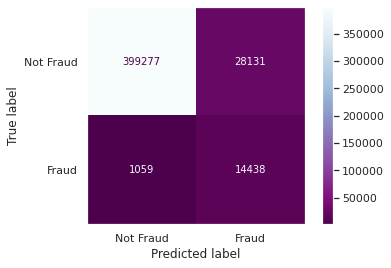

In [ ]:
y_train_pred = lgb.predict(X_train)
plot_confusion_matrix(lgb, X_train, y_train, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'], cmap=plt.cm.BuPu_r)
plt.grid(None)
print(classification_report(y_train, y_train_pred, zero_division=0))

In [ ]:
print('Test ROC AUC score:', roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1]))
print('Train ROC AUC score:', roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1]))

Test ROC AUC score: 0.953542089575534
Train ROC AUC score: 0.9837698202660208


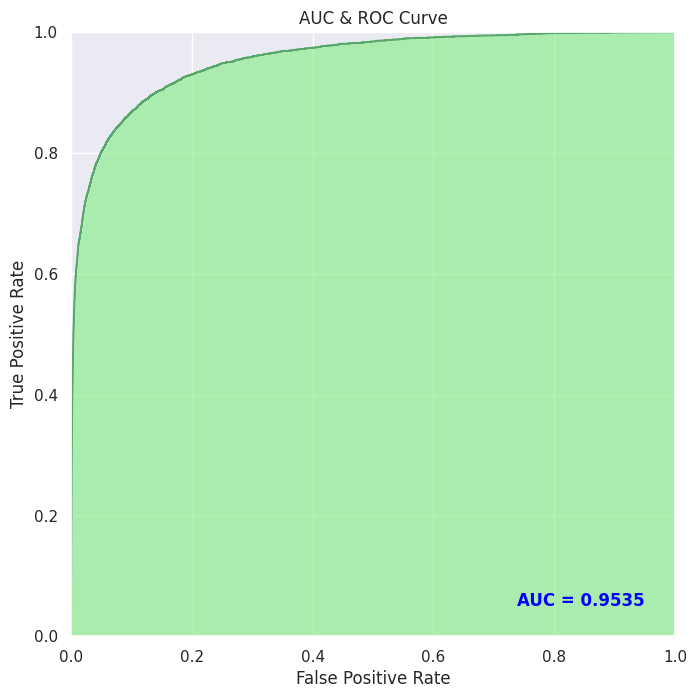

In [ ]:
from sklearn import metrics

lgb.fit(X_train, y_train)
y_pred = lgb.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#Saving the model

In [ ]:
import pickle
pickle.dump(lgb,open("./LightGBM.pkl","wb"), protocol=4)

#Training with all the train data

In [ ]:
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']

In [ ]:
# LGBMClassifier with GPU

clf = LGBMClassifier(
          max_bin = 63,
          num_leaves = 255,
          num_iterations = 500,
          learning_rate = 0.01,
          tree_learner = 'serial',
          is_dfing_metric = False,
          min_data_in_leaf = 1,
          min_sum_hessian_in_leaf = 100,
          sparse_threshold=1.0,
          # device = 'gpu',
          num_thread = -1,
          save_binary= True,
          seed= 42,
          feature_fraction_seed = 42,
          bagging_seed = 42,
          drop_seed = 42,
          data_random_seed = 42,
          objective = 'binary',
          boosting_type = 'gbdt',
          verbose = 1,
          metric = 'auc',
          is_unbalance = True,
          boost_from_average = False,
)

In [ ]:
%time 
clf.fit(X, y)
# %time prints CPU Times and Wall Time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.7 µs


LGBMClassifier(bagging_seed=42, boost_from_average=False, data_random_seed=42,
               drop_seed=42, feature_fraction_seed=42, is_dfing_metric=False,
               is_unbalance=True, learning_rate=0.01, max_bin=63, metric='auc',
               min_data_in_leaf=1, min_sum_hessian_in_leaf=100,
               num_iterations=500, num_leaves=255, num_thread=-1,
               objective='binary', save_binary=True, seed=42,
               sparse_threshold=1.0, tree_learner='serial', verbose=1)

#Predict test data

In [ ]:
sub= pd.read_csv('/content/drive/MyDrive/Final Year Project (2021-22)/Datasets/IEEE-CIS /sample_submission.csv')

In [ ]:
sub['isFraud']=pd.DataFrame(clf.predict_proba(test))[[1]]

In [ ]:
sub.to_csv('./submission.csv',index=False)

In [ ]:
sub

,TransactionID,isFraud
0,3663549,0.054434
1,3663550,0.089109
2,3663551,0.067981
3,3663552,0.111444
4,3663553,0.041301
...,...,...
506686,4170235,0.159762
506687,4170236,0.153829
506688,4170237,0.058819
506689,4170238,0.144084


# XGBoost Model

In [ ]:
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

In [ ]:
xgb = XGBClassifier()

In [ ]:
%time xgb.fit(X_train, y_train)

CPU times: user 1min 58s, sys: 224 ms, total: 1min 59s
Wall time: 1min 58s


XGBClassifier()

In [ ]:
gc.collect()

17439

In [ ]:
y_pred = xgb.predict(X_test)

##Evaluating the model

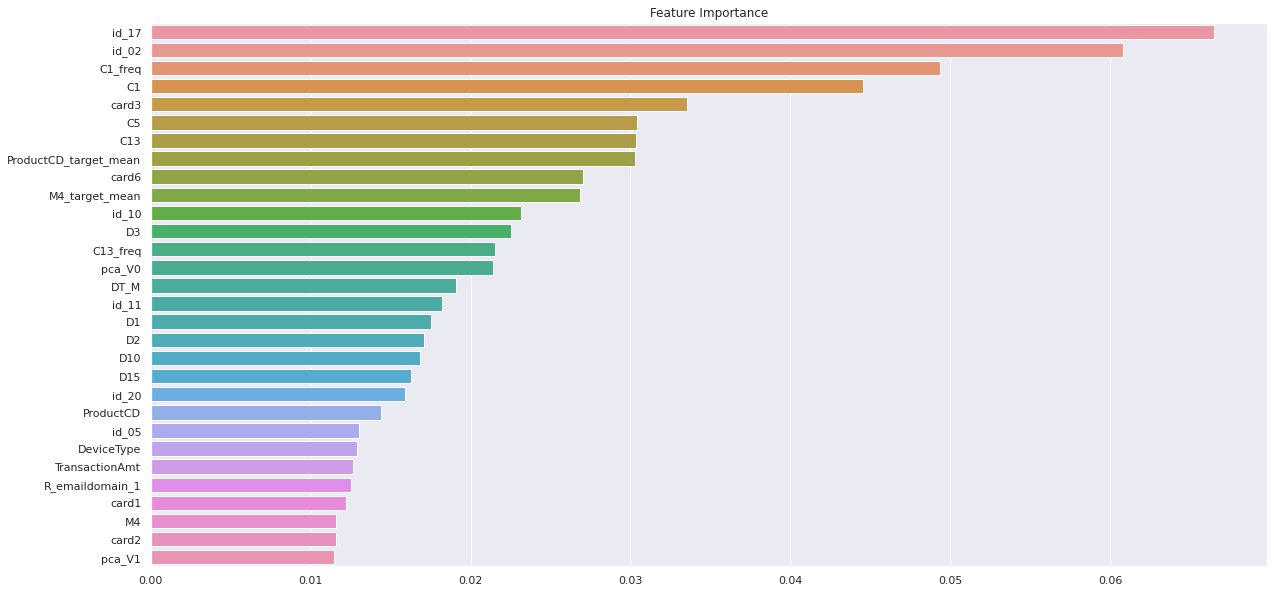

In [ ]:
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()
    
plot_feature_importances(xgb, 30)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    142469
           1       0.85      0.27      0.41      5166

    accuracy                           0.97    147635
   macro avg       0.91      0.63      0.70    147635
weighted avg       0.97      0.97      0.97    147635



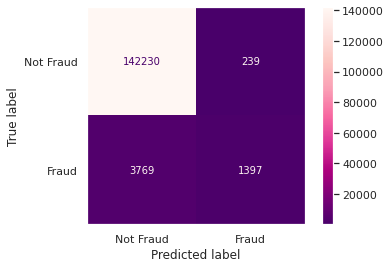

In [ ]:
plot_confusion_matrix(xgb, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'], cmap=plt.cm.RdPu_r)
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    427408
           1       0.86      0.27      0.41     15497

    accuracy                           0.97    442905
   macro avg       0.92      0.63      0.70    442905
weighted avg       0.97      0.97      0.97    442905



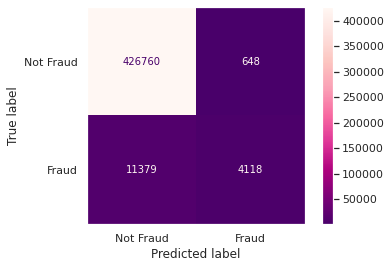

In [ ]:
y_train_pred = xgb.predict(X_train)
plot_confusion_matrix(xgb, X_train, y_train, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'], cmap=plt.cm.RdPu_r)
plt.grid(None)
print(classification_report(y_train, y_train_pred, zero_division=0))

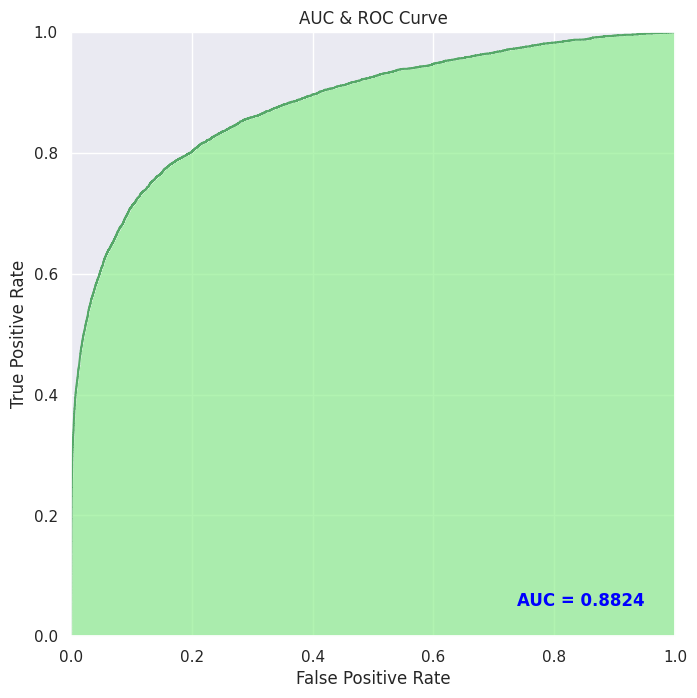

In [ ]:
from sklearn import metrics

# xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#Comparing Models

In [ ]:
y_pred = lgb.predict(X_test)
lgb_recall = recall_score(y_test, y_pred)
lgb_f1_score = f1_score(y_test, y_pred)
lgb_AUC = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])


y_pred = xgb.predict(X_test)
xgb_recall = recall_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred)
xgb_AUC = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1],average='micro')

In [ ]:
df_eval=pd.DataFrame({ 'Model':["LightGBM",'XGBOOST'],
                        'Recall':[lgb_recall,xgb_recall],
                        'F1':[lgb_f1_score,xgb_f1_score],
                        'AUC':[lgb_AUC,xgb_AUC]})
df_eval

,Model,Recall,F1,AUC
0,LightGBM,0.832365,0.447218,0.953542
1,XGBOOST,0.270422,0.410762,0.882424


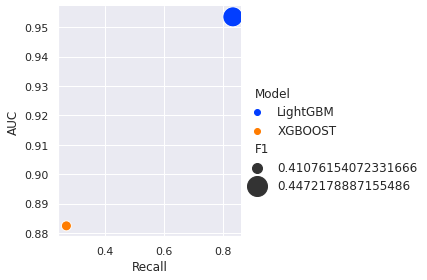

In [ ]:
sns.relplot(x="Recall", y="AUC", hue="Model", size="F1", sizes=(100, 400), 
            alpha=1, palette="bright", height=4, legend='full', data=df_eval);